## BUSINESS UNDERSTANDING

*   Define our goal
    *   We seek to better understand how end-of-play kinematic information about defensive players relates to the probability of a tackle being made
*   State why this is a relevant/important/useful problem to work on
    * Identifying relevant factors that contribute to successful tackles allows teams to reprioritize their practice regime and play calling strategies to better align with those factors that favor successful tackles.
*   State the approach that we took
    * We used PyMC to build a logistic Bayesian Additive Regression Tree (BART) model.
$$ \text{logit}\left(Y\right) = \beta_{0} + \beta_{1}X_{1} + \beta_{2}X_{2} + \beta_{3}X_{3} + \beta_{4}X_{4} $$

    * where
        * $Y = $ Binary response (1=tackle made; 0=no tackle made)
        * $X_{1} = $ Momentum of defender ending frame of play
        * $X_{2} = $ Force of defender at ending frame of play
        * $X_{3} = $ Distance to ball carrier
        * $X_{4} = $ Defensive position played






<hr>

## DATA UNDERSTANDING

#### Import Modules

In [ ]:
!pip install pymc-bart

In [ ]:
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import pytensor
import pytensor.tensor as pt
import scipy as sp
import scipy.stats as st
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split;

from scipy.spatial.distance import cdist
from tqdm.notebook import tqdm

import statsmodels.api as sm # using linear regression library for analysis
from scipy.stats import pearsonr # calculating pearson correlation

# ployly is the main tool for visualization in this notebook
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# Graphics and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

from scipy.spatial.distance import cdist
from tqdm.notebook import tqdm

import pymc as pm;
import pymc_bart as pmb;


# Style for the visualization
fonts = ['Rockwell','Oswald','Lato']
colors = ['#013369','#013f82','#0264ce','#d50a0a','#ffffff']

# remove unnecessary warnings in the output
pd.options.mode.chained_assignment = None  # default='warn'


# sanity check
os.getcwd()

#### Import Data

In [ ]:
#
# Load NFL Data
#

games = pd.read_csv('games.csv');
plays = pd.read_csv('plays.csv');
players = pd.read_csv('players.csv');
tackles = pd.read_csv('tackles.csv');

# Frame-by-Frame Tracking Data
week1 = pd.read_csv('tracking_week_1.csv');
# week9 = pd.read_csv('tracking_week_9.csv');

#### Numeric Summary of Data Features

In [ ]:
# week1.columns
# Index(['gameId', 'playId', 'nflId', 'displayName', 'frameId', 'time',
#        'jerseyNumber', 'club', 'playDirection', 'x', 'y', 's', 'a', 'dis', 'o',
#        'dir', 'event'],
#       dtype='object')

numeric_predictors = ['x', 'y', 's', 'a', 'dis', 'o', 'dir'];
week1_numeric = week1[numeric_predictors];
week1_numeric.describe().round(3);

## DATA PREPARATION

#### Feature Engineering

<ul>
  <li>Construct columns to track defensive players' distance to football and ball carrier on frame-by-frame basis.</li>
  <li>Compute force and momentum of each player on frame-by-frame basis.</li>
  <li>Compute kinetic energy and potential energy of each player in each frame. For the potential energy computation, we scale the distance by $\frac{1}{h}$, where $h$ is the distance between the ball carrier and the defender.

</ul>



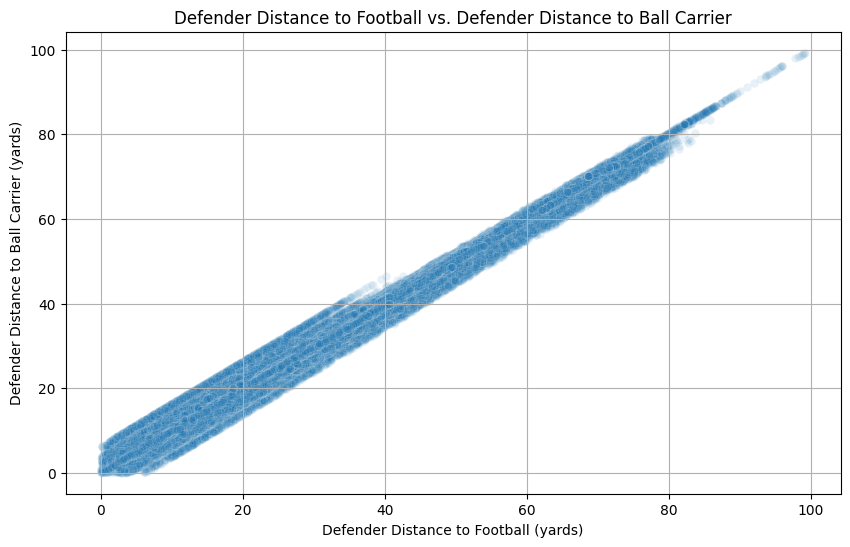

In [ ]:
#
# Create distance to ball carrier features
#



# players 	= pd.read_csv('players.csv')
# week1    	= pd.read_csv('tracking_week_1.csv')
# plays 		= pd.read_csv("plays.csv")

# Join player positioning information onto a week's worth of tracking data
week1 = week1.merge(players[['nflId']], how='left')

# Assuming 'week1' is your DataFrame containing the data
unique_game_ids = week1['gameId'].unique()

# Initialize an empty list to store dataframes for each game
game_data = []

for gid in unique_game_ids:
    game = week1.loc[week1['gameId'] == gid].copy()
    game_data.append(game)

# Concatenate all game data into one DataFrame
game = pd.concat(game_data, ignore_index=True)

# Assuming 'game' is your DataFrame containing the combined tracking data
# Separate the football's tracking data
football_tracking = game[game['nflId'].isna()]

# Initialize a column for distance to the football
game['distance_to_football'] = np.nan

# Iterate over each frame
for frame in game['frameId'].unique():
    # Extract the football's position for this frame
    football_frame = football_tracking[football_tracking['frameId'] == frame]
    if not football_frame.empty:
        football_x = football_frame.iloc[0]['x']
        football_y = football_frame.iloc[0]['y']

        # Filter the DataFrame for all players in this frame
        frame_data = game[(game['frameId'] == frame) & game['nflId'].notna()]

        # Calculate the distance of each player from the football
        distances = np.sqrt((frame_data['x'] - football_x)**2 + (frame_data['y'] - football_y)**2)

        # Assign the calculated distances to the corresponding rows in the main DataFrame
        game.loc[frame_data.index, 'distance_to_football'] = distances

# Merge the tracking data with the plays data
merged_data = game.merge(plays[['gameId', 'playId', 'ballCarrierId']], on=['gameId', 'playId'], how='left')

# Create the 'ball_carrier' column
merged_data['ball_carrier'] = (merged_data['nflId'] == merged_data['ballCarrierId']).astype(int)

# Now 'merged_data' DataFrame has an additional column 'ball_carrier' indicating if the player is carrying the ball
merged_data.head(100)

defensive_positions = ['DB', 'OLB', 'DT', 'DE', 'LB', 'ILB', 'FS', 'SS', 'CB']

# Mark defensive players in the players DataFrame
players['is_defensive_player'] = players['position'].isin(defensive_positions).astype(int)

# Merge this information with the merged_data DataFrame
merged_data = merged_data.merge(players[['nflId', 'is_defensive_player']], on='nflId', how='left')

# Fill NA values with 0 (assuming NA means the player is not defensive)
merged_data['is_defensive_player'] = merged_data['is_defensive_player'].fillna(0).astype(int)

contingency_table = pd.crosstab(index=merged_data['is_defensive_player'],
                                columns=merged_data['ball_carrier'],
                                rownames=['is_defensive_player'],
                                colnames=['ball_carrier'])

# Assuming 'merged_data' is your DataFrame containing the combined tracking data
# Separate the football's tracking data
football_tracking = merged_data[merged_data['nflId'].isna()]

# Initialize a column for defender's distance to the football
merged_data['defender_distance_to_football'] = np.nan

# Iterate over each frame
for frame in merged_data['frameId'].unique():
    # Extract the football's position for this frame
    football_frame = football_tracking[football_tracking['frameId'] == frame]
    if not football_frame.empty:
        football_x = football_frame.iloc[0]['x']
        football_y = football_frame.iloc[0]['y']

        # Filter the DataFrame for defenders in this frame
        defenders_frame = merged_data[(merged_data['frameId'] == frame) &
                                      (merged_data['is_defensive_player'] == 1)]

        # Calculate the distance of each defender from the football
        distances = np.sqrt((defenders_frame['x'] - football_x)**2 +
                            (defenders_frame['y'] - football_y)**2)

        # Assign the calculated distances to the corresponding rows in the main DataFrame
        merged_data.loc[defenders_frame.index, 'defender_distance_to_football'] = distances

# Now 'merged_data' DataFrame has an additional column 'defender_distance_to_football' with the calculated distances

# Initialize a column for defender's distance to the ball carrier
merged_data['defender_carrier_dist'] = np.nan

# Iterate over each frame
for frame in merged_data['frameId'].unique():
    # Filter the DataFrame for this frame
    frame_data = merged_data[merged_data['frameId'] == frame]

    # Find the ball carrier for the frame
    ball_carrier_row = frame_data[frame_data['ballCarrierId'] == frame_data['nflId']]
    if ball_carrier_row.empty:
        continue  # Skip if no ball carrier in this frame

    # Coordinates of the ball carrier
    ball_carrier_x = ball_carrier_row.iloc[0]['x']
    ball_carrier_y = ball_carrier_row.iloc[0]['y']

    # Calculate the distance for each defender in the frame to the ball carrier
    for idx, row in frame_data.iterrows():
        if row['is_defensive_player'] == 1:
            if pd.notna(row['x']) and pd.notna(row['y']):
                defender_carrier_dist = np.sqrt((row['x'] - ball_carrier_x)**2 +
                                                (row['y'] - ball_carrier_y)**2)
                merged_data.at[idx, 'defender_carrier_dist'] = defender_carrier_dist

# Filter out rows with NaN values for accurate plotting
filtered_data = merged_data.dropna(subset=['defender_distance_to_football', 'defender_carrier_dist'])

plt.figure(figsize=(10, 6))
sns.scatterplot(x='defender_distance_to_football', y='defender_carrier_dist', data=filtered_data, alpha=0.1)
plt.title('Defender Distance to Football vs. Defender Distance to Ball Carrier')
plt.xlabel('Defender Distance to Football (yards)')
plt.ylabel('Defender Distance to Ball Carrier (yards)')
plt.grid(True)
# plt.show()

In [ ]:
#
# Convert weight from pounds -> newtons and compute each player's mass
#

newtons_per_pound = 4.44822;
gravity = 9.81 # m/s^2
players['weight_newtons'] = newtons_per_pound*players['weight'];
players['mass_kg'] = (players['weight_newtons'] / 9.81).round(3);


#
# Compute momentum and force -> append columns to tracking data
#

merged_data = merged_data.merge(players[['nflId', 'mass_kg', 'weight_newtons']], on='nflId', how='left');

merged_data['rho'] 	= merged_data['mass_kg'] * merged_data['s'];
merged_data['force'] = merged_data['mass_kg'] * merged_data['a'];

In [ ]:
#
# Compute the Kinetic Energy and Potential Energy of each player in each frame
#

merged_data['ke']           = .5 * merged_data['mass_kg'] * merged_data['s']**2;
merged_data['pe']           = merged_data['mass_kg'] * merged_data['a'] * (1/merged_data['distance_to_football']);
merged_data['total_energy'] = merged_data['ke'] + merged_data['pe'];

merged_data = merged_data[['gameId', 'playId', 'nflId', 'displayName', 'frameId','time', 'jerseyNumber', 'club', 'playDirection', 'x', 'y', 's', 'a','dis', 'o', 'dir', 'event', 'distance_to_football', 'ballCarrierId','ball_carrier', 'is_defensive_player', 'defender_distance_to_football','defender_carrier_dist', 'mass_kg', 'weight_newtons', 'rho', 'force','ke', 'pe', 'total_energy']];

In [ ]:
#
# Filter data frame to isolate defensive players and ball carriers
#

merged_data = merged_data.query("is_defensive_player == 1");

In [ ]:
#
# Add the TME Metric
#

# Step 1: Calculate the maximum rho value for each unique combination of nflId and playId
max_rho_values = merged_data.groupby(['nflId', 'playId']).agg(max_rho=('rho', 'max')).reset_index()

# Step 2: Merge the max_rho_values back into the original data frame
merged_data = pd.merge(merged_data, max_rho_values, on=['nflId', 'playId'], how='left')

# Step 3: Create a new column rho_ratio
merged_data['rho_ratio'] = merged_data['rho'] / merged_data['max_rho']

# Step 4: Create a new column TME
merged_data['TME'] = merged_data['rho_ratio'] * np.cos(merged_data['o'])


#
# Define response variable: if (merged_data['event'] == 1) -> (merged_data['tackle_event'] == 1)
#

tackles_filtered = tackles[tackles['tackle'] == 1]

merged_with_tackles = pd.merge(
    merged_data, tackles_filtered[['gameId', 'playId', 'nflId']],
    on=['gameId', 'playId', 'nflId'],
    how='left',
    indicator=True
);

# Create the tackle_event column based on whether the merge found a match
merged_with_tackles['tackle_event'] = (merged_with_tackles['_merge'] == 'both').astype(int)
merged_with_tackles.drop(columns=['_merge'], inplace=True)

merged_data = merged_with_tackles


In [ ]:
merged_data

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,...,weight_newtons,rho,force,ke,pe,total_energy,max_rho,rho_ratio,TME,tackle_event
0,2022090800,56,38577.0,Bobby Wagner,1,2022-09-08 20:24:05.200000,45.0,LA,left,78.25,...,1076.46924,136.06768,418.07892,84.361962,45.167125,129.529087,400.52180,0.339726,-0.166554,0
1,2022090800,56,38577.0,Bobby Wagner,2,2022-09-08 20:24:05.299999,45.0,LA,left,78.20,...,1076.46924,195.32296,486.11276,173.837434,55.951910,229.789344,400.52180,0.487671,0.290935,0
2,2022090800,56,38577.0,Bobby Wagner,3,2022-09-08 20:24:05.400000,45.0,LA,left,78.16,...,1076.46924,242.50772,460.87440,267.971031,54.216583,322.187614,400.52180,0.605479,-0.306490,0
3,2022090800,56,38577.0,Bobby Wagner,4,2022-09-08 20:24:05.500000,45.0,LA,left,78.14,...,1076.46924,296.27640,424.66284,399.973140,49.627483,449.600623,400.52180,0.739726,-0.697373,0
4,2022090800,56,38577.0,Bobby Wagner,5,2022-09-08 20:24:05.599999,45.0,LA,left,78.12,...,1076.46924,334.68260,350.04508,510.390965,40.750050,551.141015,400.52180,0.835616,0.459627,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643267,2022091200,3826,54618.0,Tariq Woolen,49,2022-09-12 23:05:57.799999,27.0,SEA,left,50.75,...,911.88510,174.75540,231.45795,164.270076,6.389790,170.659866,506.60475,0.344954,-0.163341,0
643268,2022091200,3826,54618.0,Tariq Woolen,50,2022-09-12 23:05:57.900000,27.0,SEA,left,50.91,...,911.88510,171.03720,218.44425,157.354224,12.631672,169.985896,506.60475,0.337615,0.263773,0
643269,2022091200,3826,54618.0,Tariq Woolen,51,2022-09-12 23:05:58.000000,27.0,SEA,left,51.06,...,911.88510,171.96675,184.05090,159.069244,10.745531,169.814775,506.60475,0.339450,0.265207,0
643270,2022091200,3826,54618.0,Tariq Woolen,52,2022-09-12 23:05:58.099999,27.0,SEA,left,51.19,...,911.88510,171.96675,157.09395,159.069244,9.303158,168.372402,506.60475,0.339450,0.265207,0


In [ ]:
# merged_data
defensive_players

DL = ['DT', 'DE'];
LB = ['OLB', 'ILB'];
DB = ['CB', 'FS', 'SS'];



In [ ]:
# Position groups
lineman = ['DT', 'DE']
line_backer = ['OLB', 'ILB']
defensive_back = ['CB', 'FS', 'SS']

# Function to determine position group
def position_group(row):
    if row['position'] in lineman:
        return 'DL'
    elif row['position'] in line_backer:
        return 'LB'
    elif row['position'] in defensive_back:
        return 'DB'
    else:
        return 'other'

# Apply the function to create a new column
defensive_players['position_group'] = defensive_players.apply(position_group, axis=1)

# Display the modified DataFrame
defensive_players

,Unnamed: 0,nflId,height,weight,birthDate,collegeName,position,displayName,is_defensive_player,weight_newtons,mass_kg,position_group
8,8,33131,6-8,300,1986-09-01,Miami,DE,Calais Campbell,1,1334.46600,136.031,DL
15,15,35452,6-2,265,1988-04-03,Michigan,DE,Brandon Graham,1,1178.77830,120.161,DL
16,16,35454,6-5,275,1989-01-01,South Florida,DE,Jason Pierre-Paul,1,1223.26050,124.695,DL
17,17,35459,5-10,185,1988-04-10,Alabama,SS,Kareem Jackson,1,822.92070,83.886,DB
18,18,35466,5-10,195,1987-08-13,Rutgers,FS,Devin McCourty,1,867.40290,88.420,DB
...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,55200,6-6,266,NaN,Indiana,DT,Ryder Anderson,1,1183.22652,120.614,DL
1678,1679,55212,6-0,230,NaN,Iowa State,ILB,Jake Hummel,1,1023.09060,104.291,LB
1679,1680,55239,6-2,300,NaN,Pennsylvania,DT,Prince Emili,1,1334.46600,136.031,DL
1680,1681,55240,6-1,185,NaN,Buffalo,CB,Ja'Marcus Ingram,1,822.92070,83.886,DB


In [ ]:
merged_data = pd.merge(merged_data, defensive_players[['nflId', 'position_group']], on='nflId', how='left')

#### Define predictor variable matrix and response variable vector

In [ ]:
merged_data.T
merged_data.to_csv('merged_position_group.csv')

In [ ]:
merged_subset = merged_data.dropna()
df_X = merged_subset[['distance_to_football', 'rho', 'force', 'total_energy', 'TME']];
df_y = merged_subset[['tackle_event']]

In [ ]:
df_X

,distance_to_football,rho,force,total_energy,TME
1,8.688046,195.32296,486.11276,229.789344,0.290935
5,8.790687,367.60220,287.49784,648.438505,-0.669535
17,4.364311,193.12832,343.46116,248.650605,0.321845
23,8.928840,498.96066,280.58602,1011.882385,-0.634542
27,15.854014,459.60244,363.11132,854.783848,-0.628162
...,...,...,...,...,...
643214,33.499684,117.75778,265.55581,65.628426,0.071839
643222,34.957268,383.90415,411.79065,804.541899,0.757720
643224,34.452286,299.31510,430.38165,494.389418,-0.447900
643242,38.349729,451.76130,118.98240,1100.882521,0.538550


In [ ]:
df_y

,tackle_event
1,0
5,0
17,0
23,0
27,0
...,...
643214,0
643222,0
643224,0
643242,0


#### Construct Training, Testing Sets

In [ ]:
X = df_X.values;
Y = df_y['tackle_event'].values;

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1/5, random_state=69);

In [ ]:
X_train

array([[ 1.74277596e+01,  1.99196100e+02,  7.79463000e+01,
         2.33548052e+02, -3.29627437e-01],
       [ 2.85985905e+01,  1.80332700e+02,  3.15117450e+02,
         1.85941355e+02, -5.29535032e-01],
       [ 2.13180728e+01,  7.98824300e+01,  1.31452100e+02,
         3.77197880e+01,  3.70438500e-02],
       ...,
       [ 3.39315679e+01,  4.45163950e+02,  2.43972970e+02,
         8.64130751e+02,  8.80784768e-01],
       [ 4.03371625e+01,  2.10241130e+02,  2.55104300e+01,
         2.51870580e+02,  9.22580413e-01],
       [ 5.13893278e+01,  2.41455000e+01,  6.18124800e+01,
         4.22101467e+00,  1.91437418e-02]])

<hr>

## MODELING

### Random Forest Model

In [ ]:
#
# PUT RANDOM FOREST MODEL CODE HERE
#


#### XGBOOST Model

In [ ]:
#
# PUT XGBOOST MODEL CODE HERE
#


#### Logistic BART Model

<ul>
  <li>$ \text{logit}\left(p\right) \sim \text{BART}\left(h, \rho, F, \sum E, \text{TME}\right)$ [prior for parameter $p$]
  <ul>
    <li>$p = $ probability of tackle</li>
    <li>$h = $ distance between defensive player and football</li>
    <li>$\rho = mv = $ momentum (kg-$m$/$s$)</li>
    <li>$F = ma = $ force (Newtons)</li>
    <li>$\sum E = \frac{1}{2}mv^{2} + mah^{-1} = $ kinetic energy + potential energy</li>
    <li>TME = custom metric for tackler's momentum accounting for angular orientation relative to ball carrier</li>
  </ul>
  <li>$X|p \sim \text{bernoulli}\left(p\right)$ [likelihood]</li>
</ul>

In [ ]:
# PUT PyMC Logistic BART Model Here
# LOGISTIC REGRESSION
# Textbook Code: https://bayesiancomputationbook.com/markdown/chp_07.html#generalized-bart-models


with pm.Model() as model:
  μ = pmb.BART(name='μ', X=X, Y=Y, m=25);
  p = pm.Deterministic(name='p', var=pm.math.invlogit(μ));
  likelihood = pm.Bernoulli(name='likelihood', p=p, observed=Y);
  trace = pm.sample(1000, return_inferencedata=True);
  g = pm.model_to_graphviz();
  g.render('Log BART', format='png', cleanup=True)

NameError: ignored

In [ ]:
nfl_pp = pm.sample_posterior_predictive(trace, model=model, random_seed=69)

In [ ]:
az.plot_trace(trace, var_names=['μ'], compact=False)

In [ ]:
az.plot_posterior(trace, var_names=['μ'])

In [ ]:
from sklearn.metrics import roc_curve, auc

with model:
  ppc = pm.sample_posterior_predictive(trace);

print(ppc.keys())
# predicted_probs = np.mean(ppc['likelihood'], axis=0);
# fpr, tpr, _ = roc_curve(Y_test, predicted_probs);
# roc_auc = auc(fpr, tpr)

KeysView(Inference data with groups:
	> posterior_predictive
	> observed_data)


In [ ]:
from sklearn.metrics import roc_curve, auc

with model:
  ppc = pm.sample_posterior_predictive(trace);

predicted_probs = ppc.posterior_predictive["likelihood"].mean(dim=["chain", "draw"]).values
predicted_probs = np.ravel(predicted_probs)

print(predicted_probs); print('predicted lengths = ', len(predicted_probs));
print('\n');
print(Y); print('test lengths = ', len(Y))

fpr, tpr, _ = roc_curve(Y, predicted_probs)
roc_auc = auc(fpr, tpr);

print('ROC: ', roc_auc);


# fpr, tpr, _ = roc_curve(Y_test, predicted_probs)
# roc_auc = auc(fpr, tpr)

[0.118  0.07   0.09   ... 0.109  0.0545 0.071 ]
predicted lengths =  59601


[0 0 0 ... 0 0 0]
test lengths =  59601
ROC:  0.6346891415425087


In [ ]:
plt.hist(predicted_probs, color='skyblue', edgecolor='black')

NameError: ignored

<hr>

## EVALUATION

<hr>



## REFERENCES

https://www.kaggle.com/code/lichtlab/evaluate-linemen-using-player-impact-distribution - last year (top contender, Bayes)
https://www.kaggle.com/code/sethlanza/poqit-big-data-bowl-2023-submission - last year PoQuit with bayes
https://www.kaggle.com/code/s903124/bayesian-field-goal-model-with-pymc - field goal with pymc (very Bayes)

Plot post that goes with the field goal code: https://calogica.com/pymc3/python/2020/01/10/nfl-field-goals-bayes.html

Plays animation 2024: https://www.kaggle.com/code/kalilurrahman/nfl-data-bowl-2024-plays-animation

EDA & Animation 2024 (R): https://www.kaggle.com/code/khsamaha/eda-animation-nflverse-nfl-2024-r

TME Analysis 2024 (R): https://www.kaggle.com/code/richcordova/tme-nfl-data-bowl-2024#TME:-A-Scientific-Approach-to-Analyzing-Tackling-in-Football


Kaggle Models 2024 List: https://www.kaggle.com/competitions/nfl-big-data-bowl-2024/code?competitionId=60305&sortBy=voteCount

Big Data Bowl 20204: https://www.kaggle.com/competitions/nfl-big-data-bowl-2024


In [ ]:
import pymc as pm
import numpy as np

# Assuming 'merged4' is your DataFrame
X = df[['defender_carrier_dist', 'defender_distance_to_football', 'rho', 'force', 'TME', 'total_energy']].values
y = df['tackle_event'].values

with pm.Model() as model_tackle_event:
    # Priors for the intercept and coefficients
    β = pm.Normal("β", mu=0, sigma=10, shape=X.shape[1])
    β_0 = pm.Normal("β_0", mu=0, sigma=10)

    # Linear combination of predictors
    μ = β_0 + pm.math.dot(X, β)

    # Sigmoid link function
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))

    # Observations
    y_obs = pm.Bernoulli("y_obs", p=θ, observed=y)

    # Sampling from the posterior with adjusted settings
    trace_tackle_event = pm.sample(500, tune=2000, target_accept=0.95, return_inferencedata=True)

# The trace object now contains the samples from the posterior
